# Logistic Regression Pipeline for IMR90 (GREG)

This notebook assesses variaegated implementations of the logistic regression models for the data dervied from the IMR90 cell-line in GREG.

## Contents

* [1. Loading Packages](#link1)
* [2. Loading Data](#link2)
* [3. Building Model](#link3)
* [4. Dealing with the *Paradox* of Accuracy ](#link4)
    * [4.1 Problem of Class Imbalance](#link5)
        * [4.1.1 Oversampling of minority class](#link6)
        * [4.1.2 Undersampling of minority class](#link7)
        * [4.1.3 SMOTE](#link8)
        * [4.1.4 Both over- and under-sampling](#link9)
* [5. Ratifying the *Pareto's Principle*](#link10)
    * [5.1 SMOTE data](#link11)
* [6. Visualizing Predictions](#link12)
* [7. Session Information](#link13)

### <a id=link1>1. Loading Packages </a>

In [1]:
requiredPackages <- c("glmnet", "rms", "caret", "e1071", "ROSE", "DMwR", "BiocManager", "ROCR")
newPackages <- requiredPackages[!(requiredPackages %in% installed.packages()[,"Package"])]
if(length(newPackages)) install.packages(newPackages, dependencies = TRUE)

library(glmnet)
library(rms)
library(caret)
library(e1071)
library(ROSE)
library(DMwR)
library(ROCR)

Loading required package: Matrix

Loaded glmnet 4.0-2

Loading required package: Hmisc

Loading required package: lattice

Loading required package: survival

Loading required package: Formula

Loading required package: ggplot2


Attaching package: ‘Hmisc’


The following objects are masked from ‘package:base’:

    format.pval, units


Loading required package: SparseM


Attaching package: ‘SparseM’


The following object is masked from ‘package:base’:

    backsolve



Attaching package: ‘caret’


The following object is masked from ‘package:survival’:

    cluster



Attaching package: ‘e1071’


The following object is masked from ‘package:Hmisc’:

    impute


Loaded ROSE 0.0-3


Loading required package: grid

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 



### <a id=link2>2. Loading Data </a>

In [2]:
imr90gregStandard <- read.table("IMR90forML.txt", header = TRUE) ## loading full data
imr90greg <- imr90gregStandard[, -c(1:3)] ## removing the first three columns for non-usage in the ML model.

In [3]:
head(imr90greg)

,CTCF,H3K27me3,H3K36me3,H3K4me1,H3K4me2,H3K4me3,H3K9ac,H3K9me3,RNAPol2,Class
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
1,0.0000000,0.00000000,0.00000000,0.00000000,0.00000000,0,0,0.000000,0.00000000,Non-Hub
2,0.0000000,0.00000000,0.00000000,0.00000000,0.00000000,0,0,0.000000,0.00000000,Non-Hub
3,0.0000000,0.00000000,0.00000000,0.00000000,0.00000000,0,0,0.000000,0.00000000,Non-Hub
4,0.0000000,0.00000000,0.00000000,0.00000000,0.00000000,0,0,0.000000,0.00000000,Non-Hub
5,0.0000000,0.02845434,0.03670386,0.00000000,0.00000000,0,0,0.000000,0.00000000,Non-Hub
6,0.1229087,0.02845434,0.18351931,0.02756696,0.03354488,0,0,0.206122,0.05739237,Non-Hub


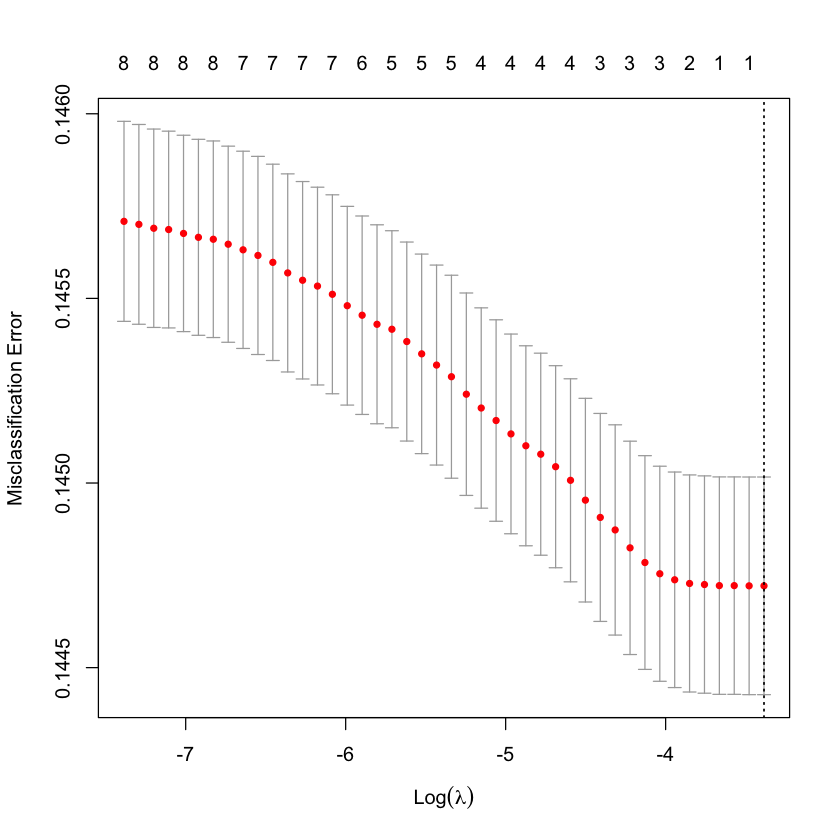

In [4]:
set.seed(005)
cv.modelfit <- cv.glmnet(as.matrix(imr90greg[,1:9]),
                         imr90greg$Class,
                         family = "binomial",
                         type.measure = "class",
                         alpha = 1,
                         nlambda = 100)


plot(cv.modelfit)

In [5]:
cat("There are", length(cv.modelfit$lambda),
    "lambda values in all:\n",
    cv.modelfit$lambda,
    "\n, out of which",
    min(cv.modelfit$lambda),
    "is the minimum, while",
    cv.modelfit$lambda.1se,
    "denotes the value at which the model is optimized at one standard error.")

There are 44 lambda values in all:
 0.03387205 0.03086295 0.02812117 0.02562296 0.02334669 0.02127264 0.01938283 0.01766092 0.01609197 0.0146624 0.01335983 0.01217298 0.01109157 0.01010623 0.009208416 0.008390366 0.007644989 0.006965829 0.006347004 0.005783154 0.005269394 0.004801276 0.004374744 0.003986103 0.003631989 0.003309333 0.003015341 0.002747467 0.002503389 0.002280995 0.002078358 0.001893722 0.001725489 0.001572201 0.001432531 0.001305269 0.001189313 0.001083657 0.0009873883 0.0008996714 0.0008197471 0.000746923 0.0006805684 0.0006201086 
, out of which 0.0006201086 is the minimum, while 0.03387205 denotes the value at which the model is optimized at one standard error.

### <a id=link3>3. Building Model </a>

In [6]:
set.seed(2)
modelfit <- glmnet(as.matrix(imr90greg[,1:9]),
                   imr90greg$Class,
                   family = "binomial",
                   alpha = 1,
                   lambda = min(cv.modelfit$lambda))

# Listing non-zero coefficients
print(modelfit$beta[,1])

        CTCF     H3K27me3     H3K36me3      H3K4me1      H3K4me2      H3K4me3 
-0.023297323 -0.130831601  0.018477270 -0.063917639  0.000000000  0.004661314 
      H3K9ac      H3K9me3      RNAPol2 
 0.005818767 -0.161959898 -0.036978466 


In [7]:
coef(modelfit)[,1]
predict(modelfit, type="coef")

(Intercept)         CTCF     H3K27me3     H3K36me3      H3K4me1      H3K4me2 
 2.067087368 -0.023297323 -0.130831601  0.018477270 -0.063917639  0.000000000 
     H3K4me3       H3K9ac      H3K9me3      RNAPol2 
 0.004661314  0.005818767 -0.161959898 -0.036978466

10 x 1 sparse Matrix of class "dgCMatrix"
                      s0
(Intercept)  2.067087368
CTCF        -0.023297323
H3K27me3    -0.130831601
H3K36me3     0.018477270
H3K4me1     -0.063917639
H3K4me2      .          
H3K4me3      0.004661314
H3K9ac       0.005818767
H3K9me3     -0.161959898
RNAPol2     -0.036978466

In [8]:
set.seed(5) # for reproducibility of results.
imr90greg$Class <- as.numeric(as.factor(imr90greg$Class))-1
part <- sample(2, nrow(imr90greg),
               replace = TRUE,
               prob = c(0.7,0.3))
train <- imr90greg[part==1,]
test <- imr90greg[part==2,]
cat("So, now we have",
    nrow(train),
    "training rows and",
    nrow(test),
    "testing rows")

imr90model <- glm(formula = Class ~ CTCF + H3K27me3 + H3K36me3 + H3K4me1 + H3K4me2 + H3K4me3 + H3K9ac + H3K9me3 + RNAPol2,
               data = train,
               family = "binomial")
summary(imr90model)

So, now we have 1198012 training rows and 512991 testing rows


Call:
glm(formula = Class ~ CTCF + H3K27me3 + H3K36me3 + H3K4me1 + 
    H3K4me2 + H3K4me3 + H3K9ac + H3K9me3 + RNAPol2, family = "binomial", 
    data = train)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.4950   0.4857   0.5200   0.5667   5.7999  

Coefficients:
             Estimate Std. Error z value Pr(>|z|)    
(Intercept)  2.077793   0.003920 530.037  < 2e-16 ***
CTCF        -0.028771   0.001962 -14.667  < 2e-16 ***
H3K27me3    -0.131824   0.001846 -71.421  < 2e-16 ***
H3K36me3     0.022344   0.001904  11.736  < 2e-16 ***
H3K4me1     -0.065410   0.002275 -28.751  < 2e-16 ***
H3K4me2     -0.005187   0.002076  -2.499   0.0125 *  
H3K4me3      0.005376   0.001241   4.332 1.48e-05 ***
H3K9ac       0.016252   0.002633   6.173 6.71e-10 ***
H3K9me3     -0.166899   0.002800 -59.617  < 2e-16 ***
RNAPol2     -0.046581   0.001886 -24.703  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken 

In [9]:
vif(imr90model)

CTCF H3K27me3 H3K36me3  H3K4me1  H3K4me2  H3K4me3   H3K9ac  H3K9me3 
1.135746 1.088460 1.166703 2.858558 5.367410 6.812794 8.175731 1.071842 
 RNAPol2 
2.021388

Since, we see that all variables are statistically significant (p < 0.05), we shall ignore the slightly higher values of <b>H3K4me3</b> and <b>H3K9ac</b>.

In [10]:
yTrain <- predict(imr90model, train, type = "response")
head(yTrain)

1         2         4         5         7        10 
0.8887260 0.8887260 0.8887260 0.8884358 0.8887260 0.8887260

In [11]:
head(train)

,CTCF,H3K27me3,H3K36me3,H3K4me1,H3K4me2,H3K4me3,H3K9ac,H3K9me3,RNAPol2,Class
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,0,0.00000000,0.00000000,0,0,0,0,0,0,1
2,0,0.00000000,0.00000000,0,0,0,0,0,0,1
4,0,0.00000000,0.00000000,0,0,0,0,0,0,1
5,0,0.02845434,0.03670386,0,0,0,0,0,0,1
7,0,0.00000000,0.00000000,0,0,0,0,0,0,1
10,0,0.00000000,0.00000000,0,0,0,0,0,0,1


In [12]:
prediction_probabilities_train <- ifelse(yTrain > 0.5, 1, 0) # Probabilities to Labels conversion
confusion_matrix_train <- table(Predicted = prediction_probabilities_train, Actual = train$Class)
print(confusion_matrix_train)

         Actual
Predicted       0       1
        0     338    1602
        1  172918 1023154


In [13]:
misclassfication_error_train <- 1- sum(diag(confusion_matrix_train))/sum(confusion_matrix_train)
cat("The misclassification error in train data is",
    (round(misclassfication_error_train*100)), "percent")

The misclassification error in train data is 15 percent

In [14]:
yTest <- predict(imr90model, test, type = "response")
prediction_probabilities_test <- ifelse(yTest > 0.5, 1, 0)
confusion_matrix_test <- table(Predicted = prediction_probabilities_test, Actual = test$Class)
print(confusion_matrix_test)

         Actual
Predicted      0      1
        0    148    725
        1  74215 437903


In [15]:
misclassfication_error_test <- 1- sum(diag(confusion_matrix_test))/sum(confusion_matrix_test)
cat("The misclassification error in test data is",
    (round(misclassfication_error_test*100)), "percent")

The misclassification error in test data is 15 percent

In [16]:
overall_p <- with(imr90model,
                  pchisq(null.deviance-deviance,
                         df.null-df.residual,
                         lower.tail = FALSE))
cat("The statistical significance for the model is", overall_p, "\n")

The statistical significance for the model is 0 


In [17]:
cat("The confidence level for this model is",
    ((1-overall_p)*100), "percent")

The confidence level for this model is 100 percent

We can clearly observe that the model has **zero sensitivity** and **high specificity**. It means that the model is highly biased towards the non-hubs and that solely accounts for the data imbalance.

### <a id=link4>4. Dealing with the *Paradox* of Accuracy  </a>

The model is highly accurate in predicting the non-hubs individually. Since the data carries significant imbalance in the classes (non-hubs are far more in number than the hubs), the prediction for the hubs might not be well suited. We need to extend the analysis for a "balanced" data. But before we delve further, let us calculate the sensitivity and specificity parameters to check how well the model is able to identify positive class labels (0: hubs).

In [18]:
sensitivity(confusion_matrix_train)

[1] 0.00195087

In [19]:
specificity(confusion_matrix_train)

[1] 0.9984367

In [20]:
sensitivity(confusion_matrix_test)

[1] 0.001990237

In [21]:
specificity(confusion_matrix_test)

[1] 0.9983471

This is clearly not what we want.

####  <a id=link5>4.1 Problem of Class Imbalance </a>

The problem of class imbalance presents a warranting scenario for data normalization in terms of class proportions. Two simple strategies to mitigate this problem are oversampling and undersampling.

#####  <a id=link5> 4.1.1 Oversampling of minority class </a>

In [22]:
table(imr90greg$Class)


      0       1 
 247619 1463384 

We can articulate that the hubs(class marked with '0') are way less than the non-hubs. To scale them in proportion to the non-hubs, we can choose to oversample their instances. This is carried out by randomly choosing their exisiting data points and repeating to match a specified number. The package ***ROSE*** comes in handy here. The details about the package could be found [here](https://www.rdocumentation.org/packages/ROSE/versions/0.0-3).

In [23]:
overTrain <- ovun.sample(Class ~., data = train, method = "over", N = 1463384)$data

In [24]:
table(overTrain$Class)


      0       1 
 438628 1024756 

Still better. Let's run the model again to see if there is any improvement in the performance.

In [25]:
imr90modelOver <- glm(formula = Class ~ CTCF + H3K27me3 + H3K36me3 + H3K4me1 + H3K4me2 + H3K4me3 + H3K9ac + H3K9me3 + RNAPol2,
               data = overTrain,
               family = "binomial")
summary(imr90modelOver)


Call:
glm(formula = Class ~ CTCF + H3K27me3 + H3K36me3 + H3K4me1 + 
    H3K4me2 + H3K4me3 + H3K9ac + H3K9me3 + RNAPol2, family = "binomial", 
    data = overTrain)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.1887  -1.3998   0.7482   0.8365   6.3296  

Coefficients:
              Estimate Std. Error  z value Pr(>|z|)    
(Intercept)  1.1877361  0.0028293  419.805  < 2e-16 ***
CTCF        -0.0311315  0.0014727  -21.139  < 2e-16 ***
H3K27me3    -0.1508365  0.0014818 -101.791  < 2e-16 ***
H3K36me3     0.0195358  0.0013376   14.605  < 2e-16 ***
H3K4me1     -0.0687365  0.0016933  -40.592  < 2e-16 ***
H3K4me2     -0.0044027  0.0015014   -2.932  0.00336 ** 
H3K4me3      0.0077111  0.0009042    8.528  < 2e-16 ***
H3K9ac       0.0166806  0.0019248    8.666  < 2e-16 ***
H3K9me3     -0.1782967  0.0020903  -85.296  < 2e-16 ***
RNAPol2     -0.0628119  0.0016980  -36.992  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter 

In [26]:
yTestOver <- predict(imr90modelOver, test, type = "response")
prediction_probabilities_testOver <- ifelse(yTestOver > 0.5, 1, 0)
confusion_matrix_testOver <- table(Predicted = prediction_probabilities_testOver, Actual = test$Class)
print(confusion_matrix_testOver)

         Actual
Predicted      0      1
        0   2621   8427
        1  71742 430201


In [27]:
cat("The sensitivity of the model is", (sensitivity(confusion_matrix_testOver))*100, "%")

The sensitivity of the model is 3.524602 %

In [28]:
cat("The specificity of the model is", (specificity(confusion_matrix_testOver))*100, "%")

The specificity of the model is 98.07878 %

This is better than before but still not good enough. Maybe we can try the other approach.

##### <a id=link5> 4.1.2 Undersampling of majority class  </a>

Contrary to what we did above, we shall now scale down the random data points from the majority class and see if the model performs any better.

In [29]:
underTrain <- ovun.sample(Class ~., data = train, method = "under", N= 350000)$data
table(underTrain$Class)


     0      1 
173256 176744 

In [30]:
imr90modelUnder <- glm(formula = Class ~ CTCF + H3K27me3 + H3K36me3 + H3K4me1 + H3K4me2 + H3K4me3 + H3K9ac + H3K9me3 + RNAPol2,
               data = underTrain,
               family = "binomial")
summary(imr90modelUnder)


Call:
glm(formula = Class ~ CTCF + H3K27me3 + H3K36me3 + H3K4me1 + 
    H3K4me2 + H3K4me3 + H3K9ac + H3K9me3 + RNAPol2, family = "binomial", 
    data = underTrain)

Deviance Residuals: 
   Min      1Q  Median      3Q     Max  
-1.945  -1.188   1.012   1.118   4.812  

Coefficients:
             Estimate Std. Error z value Pr(>|z|)    
(Intercept)  0.395611   0.005462  72.426  < 2e-16 ***
CTCF        -0.033468   0.003058 -10.944  < 2e-16 ***
H3K27me3    -0.167794   0.003146 -53.330  < 2e-16 ***
H3K36me3     0.019038   0.002548   7.473 7.87e-14 ***
H3K4me1     -0.073501   0.003424 -21.465  < 2e-16 ***
H3K4me2     -0.002668   0.002903  -0.919    0.358    
H3K4me3      0.009317   0.001748   5.330 9.80e-08 ***
H3K9ac       0.018350   0.003720   4.933 8.09e-07 ***
H3K9me3     -0.185139   0.004175 -44.342  < 2e-16 ***
RNAPol2     -0.085389   0.004062 -21.021  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be

In [31]:
yTestUnder <- predict(imr90modelUnder, test, type = "response")
prediction_probabilities_testUnder <- ifelse(yTestUnder > 0.5, 1, 0)
confusion_matrix_testUnder <- table(Predicted = prediction_probabilities_testUnder, Actual = test$Class)
print(confusion_matrix_testUnder)

         Actual
Predicted      0      1
        0  34889 133048
        1  39474 305580


In [32]:
cat("The sensitivity of the model is", (sensitivity(confusion_matrix_testUnder))*100, "%")

The sensitivity of the model is 46.91715 %

In [33]:
cat("The specificity of the model is", (specificity(confusion_matrix_testUnder))*100, "%")

The specificity of the model is 69.66724 %

This case is quite balanced, not only in terms of respective data points but also sensivitiy and specificity of the classifier.

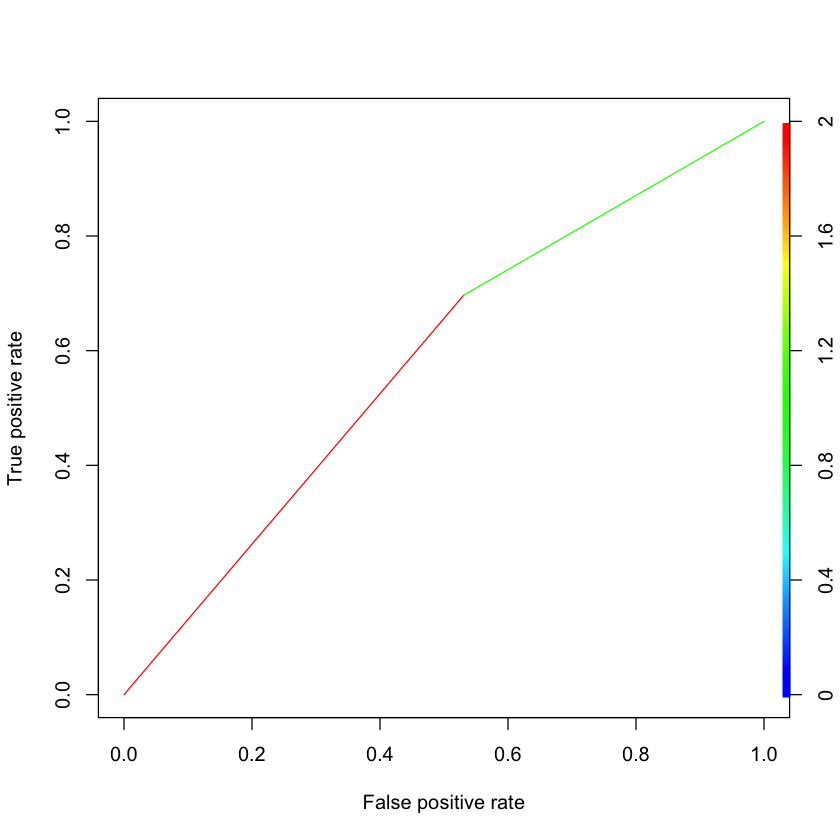

In [34]:
pred <- prediction(prediction_probabilities_testUnder, test$Class)
perf <- performance(pred, "tpr", "fpr")
plot(perf, colorize = TRUE)

##### <a id=link8> 4.1.3 SMOTE  </a>

The sampling techniques are straighforward, but could possibly engender a classifier that overfits the training data and hence might not be suitable for a general application. To handle such a chance, [SMOTE](https://www3.nd.edu/~dial/publications/chawla2002smote.pdf) was introduced by Chawla et al. in 2002 and the functionality is available in R with the package *DMwR*.

In [35]:
## Smote : Synthetic Minority Oversampling Technique
## A pre-requisite is that the class variable in the data must be of "factor" category. Let's do that conversion.

train$Class <- as.factor(train$Class)

smoteData <- SMOTE(Class ~., train, perc.over = 1000, k = 5, perc.under = 100)

table(smoteData$Class)


      0       1 
1905816 1732560 

In [36]:
imr90modelSMOTE <- glm(formula = Class ~ CTCF + H3K27me3 + H3K36me3 + H3K4me1 + H3K4me2 + H3K4me3 + H3K9ac + H3K9me3 + RNAPol2,
                    data = smoteData,
                    family = "binomial")
summary(imr90modelSMOTE)


Call:
glm(formula = Class ~ CTCF + H3K27me3 + H3K36me3 + H3K4me1 + 
    H3K4me2 + H3K4me3 + H3K9ac + H3K9me3 + RNAPol2, family = "binomial", 
    data = smoteData)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.8630  -1.1478  -0.8135   1.1565   6.7342  

Coefficients:
              Estimate Std. Error  z value Pr(>|z|)    
(Intercept)  0.2797170  0.0017005  164.486   <2e-16 ***
CTCF        -0.0311475  0.0009585  -32.496   <2e-16 ***
H3K27me3    -0.1738349  0.0009977 -174.228   <2e-16 ***
H3K36me3     0.0206227  0.0007930   26.007   <2e-16 ***
H3K4me1     -0.0777648  0.0010805  -71.968   <2e-16 ***
H3K4me2     -0.0004639  0.0009136   -0.508    0.612    
H3K4me3      0.0086734  0.0005549   15.631   <2e-16 ***
H3K9ac       0.0167584  0.0011822   14.176   <2e-16 ***
H3K9me3     -0.1811426  0.0013005 -139.291   <2e-16 ***
RNAPol2     -0.0817586  0.0012736  -64.196   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter 

Let us now examine this model with the test data.

In [37]:
yTestSMOTE <- predict(imr90modelSMOTE, test, type = "response")
prediction_probabilities_testSMOTE <- ifelse(yTestSMOTE > 0.5, 1, 0)

The confusion matrix is
         Actual
Predicted      0      1
        0  46620 197863
        1  27743 240765
The sensitivity of the model is 62.69247 % 
The specificity of the model is 54.89048 % 
The area under curve is 0.5879147 
The statistical significance for the model is 0 
The confidence level for the model is 100 percent

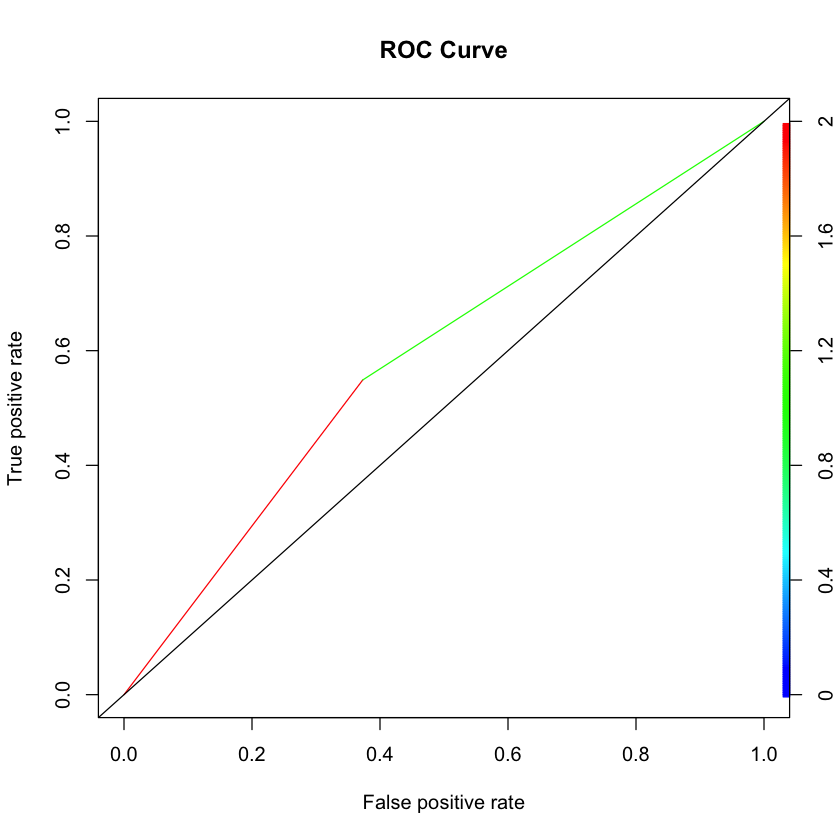

In [38]:
## Load a manually curated function 'modelPerformance()' to ascertain model performance
## Trace the function definition in the parent folder

source("modelPerformance.R")
modelPerformance(imr90modelSMOTE, test, test$Class)

##### <a id=link9> 4.1.4 Both over- and under-sampling </a>

This model has slightly better specificity than the previous model. In tandem, we could also try yet another flavor of the *ovun.sample()* function - to have under- and over-sampling both in parallel. This could be a likely run like the SMOTE as above.

In [50]:
bothTrain <- ovun.sample(Class ~., data = train, method = "both", N= 1463384)$data
table(bothTrain$Class)


     1      0 
731524 731860 

In [51]:
imr90modelBoth <- glm(formula = Class ~ CTCF + H3K27me3 + H3K36me3 + H3K4me1 + H3K4me2 + H3K4me3 + H3K9ac + H3K9me3 + RNAPol2,
               data = bothTrain,
               family = "binomial")
summary(imr90modelBoth)


Call:
glm(formula = Class ~ CTCF + H3K27me3 + H3K36me3 + H3K4me1 + 
    H3K4me2 + H3K4me3 + H3K9ac + H3K9me3 + RNAPol2, family = "binomial", 
    data = bothTrain)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-6.7840  -1.1238   0.2054   1.1808   1.9306  

Coefficients:
              Estimate Std. Error  z value Pr(>|z|)    
(Intercept) -0.3780844  0.0026769 -141.241   <2e-16 ***
CTCF         0.0294239  0.0014994   19.623   <2e-16 ***
H3K27me3     0.1725008  0.0015505  111.258   <2e-16 ***
H3K36me3    -0.0184217  0.0012493  -14.746   <2e-16 ***
H3K4me1      0.0747657  0.0016968   44.062   <2e-16 ***
H3K4me2      0.0021246  0.0014565    1.459    0.145    
H3K4me3     -0.0097025  0.0008794  -11.034   <2e-16 ***
H3K9ac      -0.0168510  0.0018634   -9.043   <2e-16 ***
H3K9me3      0.1846777  0.0020424   90.423   <2e-16 ***
RNAPol2      0.0867393  0.0020143   43.061   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter 

The confusion matrix is
         Actual
Predicted      0      1
        0  37505 295809
        1  36858 142819
The sensitivity of the model is 50.43503 % 
The specificity of the model is 32.56039 % 
The area under curve is 0.4149771 
The statistical significance for the model is 0 
The confidence level for the model is 100 percent

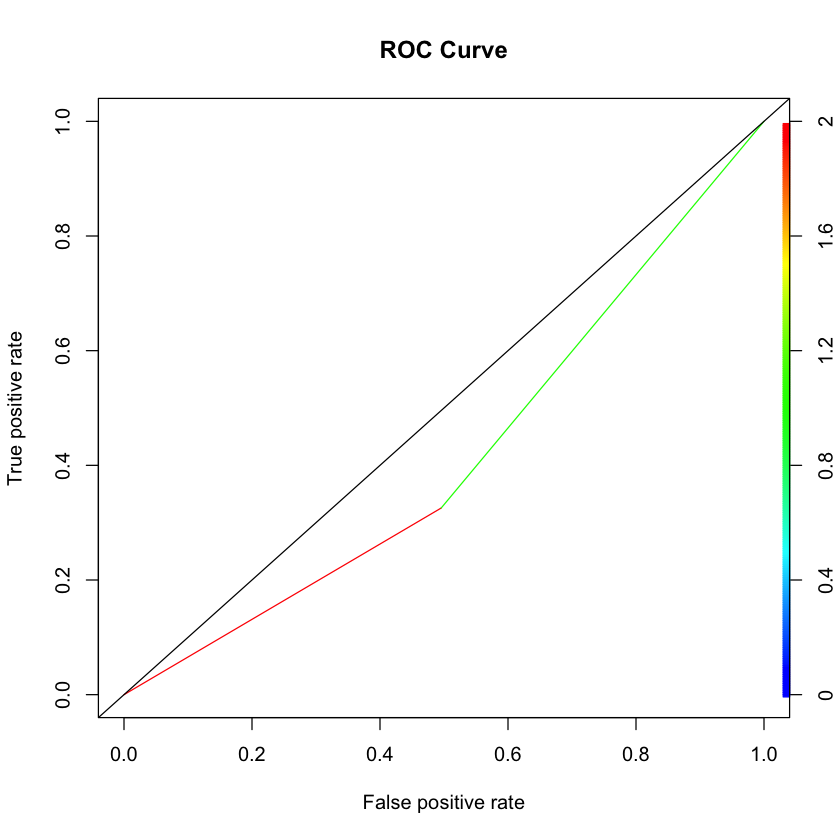

In [52]:
yTestBoth <- predict(imr90modelBoth, test, type = "response")
prediction_probabilities_testBoth <- ifelse(yTestBoth > 0.5, 1, 0)
modelPerformance(imr90modelBoth, test, test$Class)

These numbers aren't as good. Hitherto, the model with SMOTE data has performed the best.

### <a id=link10>5. Ratifying the *Pareto's Principle* </a>

The 80:20 rule is omnipresent in the domains of business and economy. Hardly would have the italian economist known at the time that his [theory](https://en.wikipedia.org/wiki/Pareto_principle) would be rooted deeper than his perception. 

In [53]:
set.seed(6) # for reproducibility of results.
parts <- sample(2, nrow(imr90greg),
               replace = TRUE,
               prob = c(0.8,0.2))
training <- imr90greg[parts==1,]
testing <- imr90greg[parts==2,]
cat("So, now we have", nrow(training), "training rows and", nrow(testing), "testing rows")

So, now we have 1368935 training rows and 342068 testing rows

In [54]:
imr90paretoModel <- glm(formula = Class ~ ., data = training, family = "binomial")
summary(imr90paretoModel)

Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”



Call:
glm(formula = Class ~ ., family = "binomial", data = training)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.5223   0.4866   0.5208   0.5672   8.4904  

Coefficients:
             Estimate Std. Error z value Pr(>|z|)    
(Intercept)  2.073790   0.003661 566.502  < 2e-16 ***
CTCF        -0.028544   0.001839 -15.518  < 2e-16 ***
H3K27me3    -0.130926   0.001721 -76.075  < 2e-16 ***
H3K36me3     0.022325   0.001782  12.527  < 2e-16 ***
H3K4me1     -0.064876   0.002124 -30.550  < 2e-16 ***
H3K4me2     -0.004978   0.001935  -2.573   0.0101 *  
H3K4me3      0.005969   0.001154   5.174 2.29e-07 ***
H3K9ac       0.014724   0.002439   6.037 1.57e-09 ***
H3K9me3     -0.166242   0.002612 -63.648  < 2e-16 ***
RNAPol2     -0.045485   0.001751 -25.969  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 1132896  on 1368934  degrees of freedom
Residual deviance: 111

The confusion matrix is
         Actual
Predicted      0      1
        0     98    446
        1  49141 292383
The sensitivity of the model is 0.1990292 % 
The specificity of the model is 99.84769 % 
The area under curve is 0.5002336 
The statistical significance for the model is 0 
The confidence level for the model is 100 percent

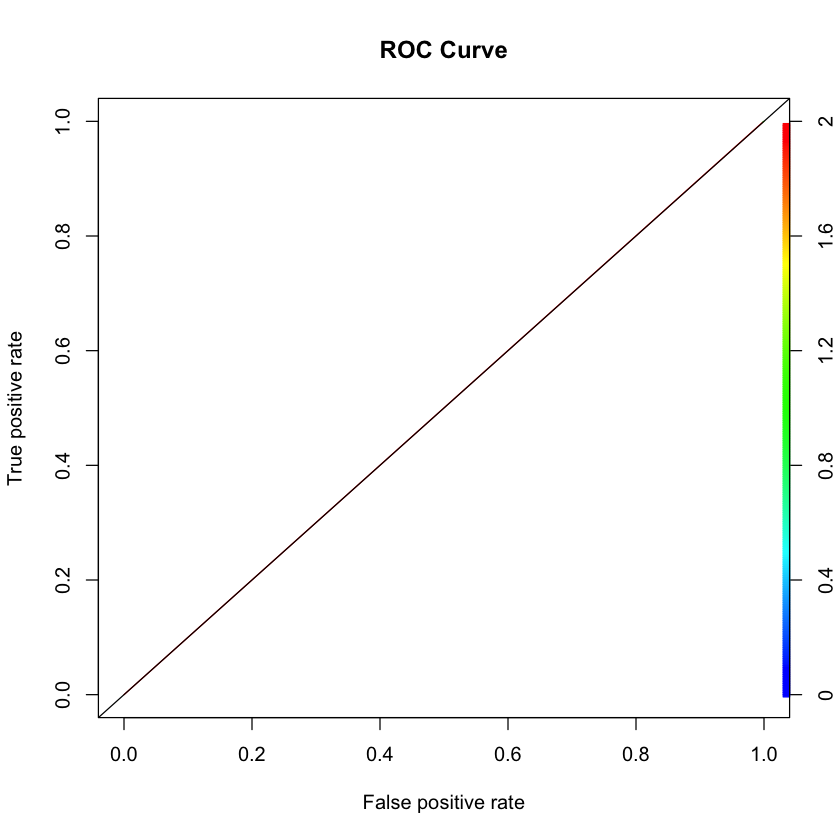

In [55]:
yTesting <- predict(imr90paretoModel, testing, type = "response")
prediction_probabilities_testing <- ifelse(yTesting > 0.5, 1, 0)
modelPerformance(imr90paretoModel, testing, testing$Class)

We see here that the issue of class imbalance imposes skewness on the classifier to predict solely non-hubs (represented by "1"). The balancing of the data, as practiced above, might come to the rescue. Let's examine the performance of the classifier on SMOTE transformed data.

#### <a id=link11>5.1 SMOTE data </a>

In [ ]:
training$Class <- as.factor(training$Class)
smoteDatum <- SMOTE(Class ~., training, perc.over = 10000, k = 5, perc.under = 100)
table(smoteDatum$Class)

In [50]:
imr90paretoModelSmote <- glm(formula = Class ~ ., data = smoteDatum, family = "binomial")
summary(imr90paretoModelSmote)


Call:
glm(formula = Class ~ ., family = "binomial", data = smoteDatum)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.4497  -1.1838  -0.2159   1.1108   6.4450  

Coefficients:
              Estimate Std. Error  z value Pr(>|z|)    
(Intercept)  0.4062600  0.0019438  209.005  < 2e-16 ***
CTCF        -0.1107978  0.0017051  -64.981  < 2e-16 ***
EP300       -0.1293084  0.0022420  -57.676  < 2e-16 ***
H3K27me3    -0.0829513  0.0012676  -65.439  < 2e-16 ***
H3K36me3    -0.2533316  0.0016448 -154.024  < 2e-16 ***
H3K4me1     -0.0895072  0.0007138 -125.398  < 2e-16 ***
H3K4me2      0.0266678  0.0010963   24.325  < 2e-16 ***
H3K4me3     -0.0212485  0.0009982  -21.287  < 2e-16 ***
H3K9ac      -0.0004557  0.0002395   -1.903   0.0571 .  
H3K9me3      0.1142932  0.0012627   90.514  < 2e-16 ***
RAD21        0.0517232  0.0017979   28.768  < 2e-16 ***
RNAPol2      0.0028134  0.0004227    6.656 2.81e-11 ***
YY1         -0.0191502  0.0027477   -6.969 3.18e-12 ***
---
Signif. cod

In [51]:
yTestingSmote <- predict(a549paretoModelSmote, testing, type = "response")
prediction_probabilities_testingSmote <- ifelse(yTestingSmote > 0.5, 1, 0)
modelPerformance(imr90paretoModelSmote, testing, testing$Class)

         Actual
Predicted      0      1
        0    187  92251
        1    224 216848


### <a id=link12>6. Visualizing Predictions </a>

We choose to go with this model and will save the prediction results, that shall be later utilized for plotting.

In [55]:
a549gregModelPredictions <- predict(a549paretoModelSmote, a549greg, type = "response")
a549gregModelPredictionsProbs <- ifelse(a549gregModelPredictions > 0.5, 1, 0)

Eventually, we have the original dataset with the classes and the one with the model predictions. We attempt to map the prediction results corresponding to LR-Hubs from the A549 cell-line. It will be interesting to see the intersect of the pre-caliberated LR-Hubs and the ones predicted by the classifier.

<a href = "http://www.bioconductor.org/packages/release/bioc/html/Gviz.html" > Gviz </a> is the package we aim to deploy for visualization.

In [56]:
if(!requireNamespace("BiocManager", quietly = TRUE))
BiocManager::install("Gviz")
library(Gviz)

Loading required package: S4Vectors

Loading required package: stats4

Loading required package: BiocGenerics

Loading required package: parallel


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB


The following object is masked from ‘package:Matrix’:

    which


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    Filter, Find, Map, Position, Reduce, anyDuplicated, append,
    as.data.frame, basename, cbind, colnames, dirname, do.call,
    duplicated, eval, evalq, get, grep, grepl, intersect, is.unsorted,
    lapply, mapply, match, mget, order, paste, pmax, pmax.int, pmin,
    pmin.int, rank, rbind, rownames, sapply, setdiff, sort, table,
    tapply, union, unique, unsplit, 

<p align="justify"> Next, we recall the data from the A549 cell-line (GREG). We already know, this is a comprehensive data (genome-wide) with values corresponding to epigenetic marks (features) for each bin (a 2Kb genomic region), in addition to a "Class", i.e. a "Hub" or a "Non-Hub". For the present case, we shall prune the data for the genomic intervals and their corresponding class. That is all we need! </p>

In [57]:
a549gregStandardRegionsClass <- a549gregStandard[, c(1:3,16)]

Also, considering the computational resources we deploy, we shall focus on chromosome 21 only.

In [58]:
# Extracting chr21 data

a549gregChr21NonHub <- a549gregStandardRegionsClass[a549gregStandardRegionsClass$chr=="chr21" & a549gregStandardRegionsClass$Class=="Non-Hub", ] ## subset of data for exemplifying
a549gregChr21Hub <- a549gregStandardRegionsClass[a549gregStandardRegionsClass$chr=="chr21" & a549gregStandardRegionsClass$Class=="Hub", ]

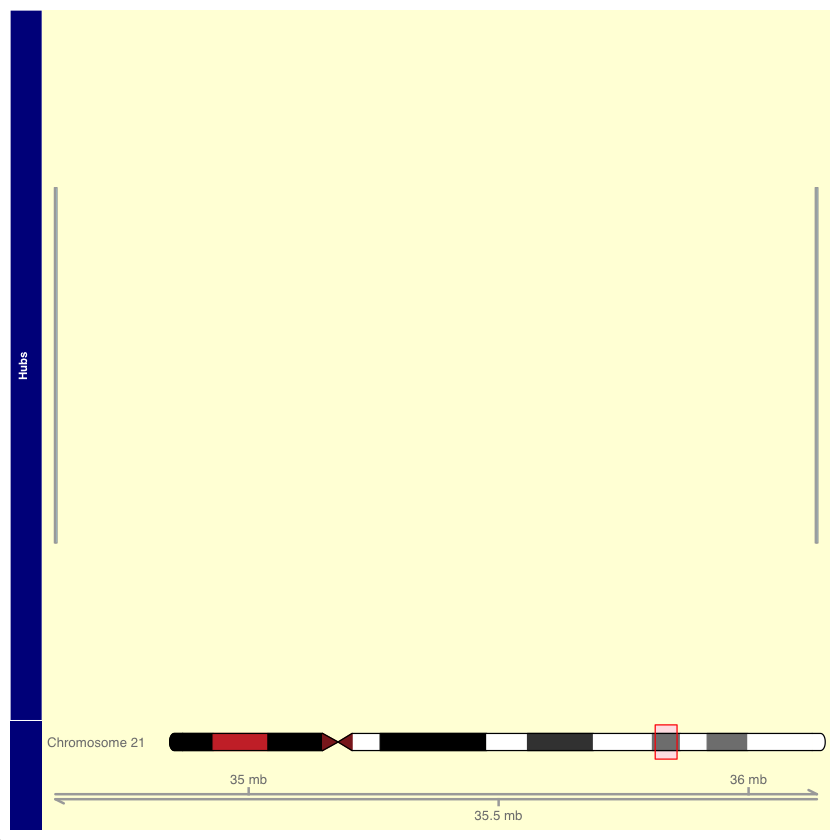

In [59]:
# Plotting Hubs

annotationTrackHub <- AnnotationTrack(range = a549gregChr21Hub, 
                                      name = "Hubs", 
                                      genome = "hg38", 
                                      chromosome = "chr21")
itrack <- IdeogramTrack(genome = "hg38", chromosome = "chr21")
genomeTrack <- GenomeAxisTrack()
plotTracks(list(annotationTrackHub, itrack, genomeTrack), 
           background.panel = "#FFFEDB", 
           background.title = "darkblue",
           stacking = "dense")

So, there is a narrow occurrence of "hubs" in the chromosome 21, as seen above. The specific locations are given below.

In [60]:
print(a549gregChr21Hub)

         chr    start      end Class
814391 chr21 34612001 34614000   Hub
814392 chr21 34614001 34616000   Hub
815152 chr21 36134001 36136000   Hub
815153 chr21 36136001 36138000   Hub


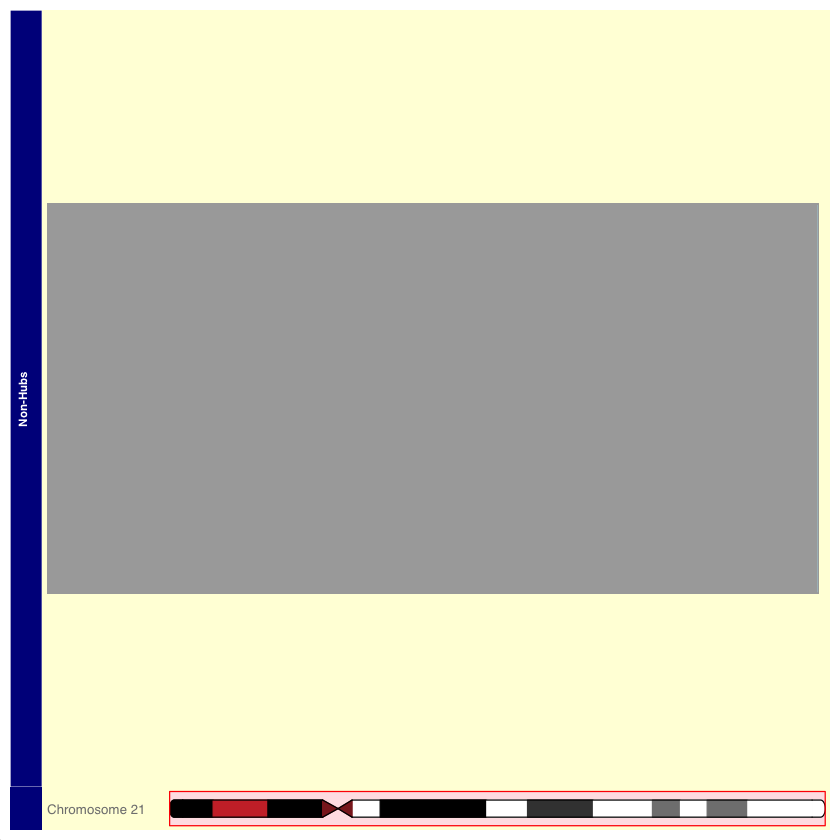

In [61]:
# Plotting Non-Hubs

annotationTrackNonHub <- AnnotationTrack(range = a549gregChr21NonHub, 
                                         name = "Non-Hubs", 
                                         genome = "hg38", 
                                         chromosome = "chr21")
itrack <- IdeogramTrack(genome = "hg38", chromosome = "chr21")
plotTracks(list(annotationTrackNonHub, itrack),
           background.panel = "#FFFEDB", 
           background.title = "darkblue",
           stacking = "dense")

We can observe that the Non-Hubs are pretty evenly distributed throughout the chromosome.In contrast, we are curious to examine if the findings of the classifier are able to fortify the original class definitions. Let us frame the data from the predicted results.  

In [62]:
a549gregPredicted <- cbind(a549gregStandardRegionsClass, a549gregModelPredictionsProbs)
names(a549gregPredicted)[names(a549gregPredicted)=="a549gregModelPredictionsProbs"] <- "Prediction"
a549gregPredicted$Prediction <- ifelse(a549gregPredicted$Prediction == 1, "Non-Hub", "Hub")            

Let us see if the classifier predictions match with the original results.

In [63]:
a549gregChr21PredicitedHub <- a549gregPredicted[a549gregPredicted$chr=="chr21" & a549gregPredicted$Prediction =="Hub", ]
print(a549gregChr21PredicitedHub)

         chr    start      end   Class Prediction
801933 chr21  9696001  9698000 Non-Hub        Hub
801934 chr21  9698001  9700000 Non-Hub        Hub
801997 chr21  9824001  9826000 Non-Hub        Hub
801998 chr21  9826001  9828000 Non-Hub        Hub
801999 chr21  9828001  9830000 Non-Hub        Hub
802000 chr21  9830001  9832000 Non-Hub        Hub
802001 chr21  9832001  9834000 Non-Hub        Hub
802002 chr21  9834001  9836000 Non-Hub        Hub
802003 chr21  9836001  9838000 Non-Hub        Hub
802004 chr21  9838001  9840000 Non-Hub        Hub
802006 chr21  9842001  9844000 Non-Hub        Hub
802435 chr21 10700001 10702000 Non-Hub        Hub
802628 chr21 11086001 11088000 Non-Hub        Hub
802639 chr21 11108001 11110000 Non-Hub        Hub
802670 chr21 11170001 11172000 Non-Hub        Hub
802671 chr21 11172001 11174000 Non-Hub        Hub
802672 chr21 11174001 11176000 Non-Hub        Hub
802674 chr21 11178001 11180000 Non-Hub        Hub
802675 chr21 11180001 11182000 Non-Hub        Hub


Certainly, the predicted hubs are far more in number and there are noticeable instances of "Non-Hubs" that have been classified as "Hubs", with the given profile of the classification model.  

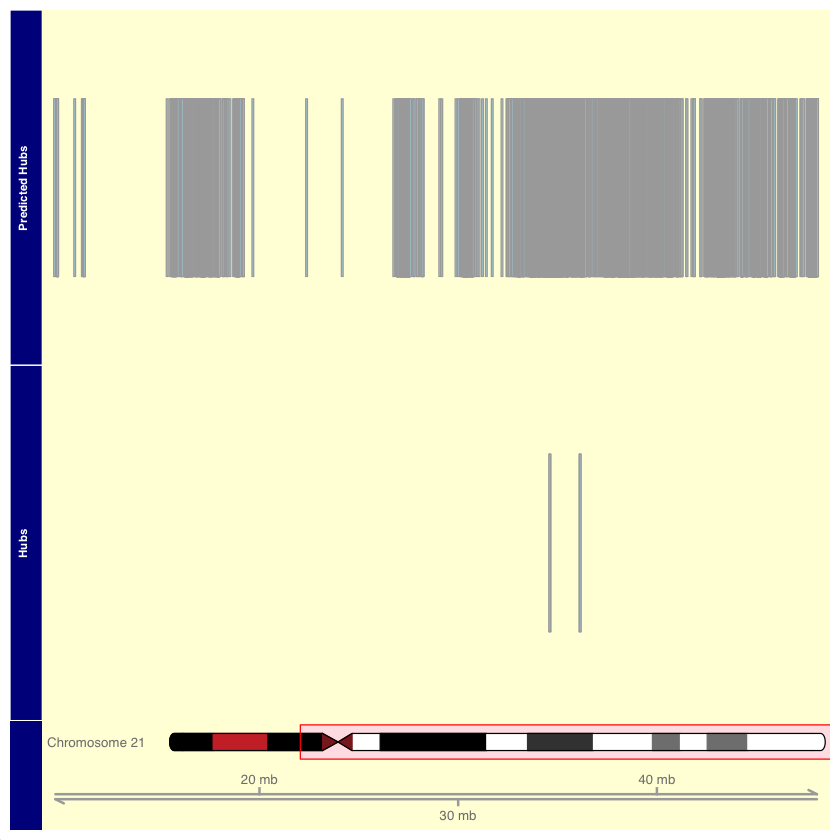

In [64]:
# Plotting Predicted Hubs
annotationTrackHub <- AnnotationTrack(range = a549gregChr21Hub, 
                                      name = "Hubs", 
                                      genome = "hg38", 
                                      chromosome = "chr21")
annotationTrackPredictedHub <- AnnotationTrack(range = a549gregChr21PredicitedHub, 
                                               name = "Predicted Hubs", 
                                               genome = "hg38", 
                                               chromosome = "chr21")
itrack <- IdeogramTrack(genome = "hg38", chromosome = "chr21")
genomeTrack <- GenomeAxisTrack()
plotTracks(list(annotationTrackPredictedHub,annotationTrackHub, itrack, genomeTrack), 
           background.panel = "#FFFEDB", 
           background.title = "darkblue",
           stacking = "dense")

### <a id=link13>7. Session Information </a>

In [65]:
sessionInfo()

R version 4.0.2 (2020-06-22)
Platform: x86_64-apple-darwin17.0 (64-bit)
Running under: macOS Catalina 10.15.6

Matrix products: default
BLAS:   /Library/Frameworks/R.framework/Versions/4.0/Resources/lib/libRblas.dylib
LAPACK: /Library/Frameworks/R.framework/Versions/4.0/Resources/lib/libRlapack.dylib

locale:
[1] C/UTF-8/C/C/C/C

attached base packages:
 [1] parallel  stats4    grid      stats     graphics  grDevices utils    
 [8] datasets  methods   base     

other attached packages:
 [1] Gviz_1.32.0          GenomicRanges_1.40.0 GenomeInfoDb_1.24.2 
 [4] IRanges_2.22.2       S4Vectors_0.26.1     BiocGenerics_0.34.0 
 [7] ROCR_1.0-11          DMwR_0.4.1           ROSE_0.0-3          
[10] e1071_1.7-3          caret_6.0-86         rms_6.0-1           
[13] SparseM_1.78         Hmisc_4.4-1          ggplot2_3.3.2       
[16] Formula_1.2-3        survival_3.2-3       lattice_0.20-41     
[19] glmnet_4.0-2         Matrix_1.2-18       

loaded via a namespace (and not attached):
  [1] uui